In [1]:
import pandas as pd
import numpy as np
from ojsim import OJSimulator

sim = OJSimulator(step_size=10)

In [2]:
X, Y = sim.dataset.submit_train

In [3]:
X.shape, Y.shape

((26349, 2, 1440, 10), (26349, 10))

In [6]:
# construct the huge dim input dataset
def transform(X):
    prices = X[:,0,[-30,-1],:]
    price_diff = (X[:,0,1:,:] - X[:,0,:-1,:])[:,-30:,:]
    volu = np.log(X[:,1,:,:] + 1)[:,[-30, -1],:]
    volu_diff = (np.log(X[:,1,1:,:] + 1) - np.log(X[:,1,:-1,:] + 1))[:,-30:,:]
    X_train = np.concatenate([prices, price_diff, volu, volu_diff], axis=1)
    return X_train

X_train = transform(X)
print(X_train.shape)
N, _, _ = X_train.shape

(17709, 64, 10)


In [5]:
y = Y - X[:,0,-1,:]

In [5]:
from sklearn.linear_model import LinearRegression

In [7]:
model = []
for i in range(10):
    model.append(LinearRegression().fit(X_train[:,:,i], y[:,i]))
    print(i)

0
1
2
3
4
5
6
7
8
9


In [8]:
for i in range(10):
    print(model[i].score(X_train[:,:,i], y[:,i]))

0.009690666119378633
0.017922249756588404
0.008805042657716422
0.012180069501187996
0.02550292580153013
0.009043094119266182
0.011906997589822055
0.011395441791836824
0.020539089196362048
0.020660068835310796


In [13]:
import pickle
# with open('./linreg.pkl', 'wb') as f:
#     pickle.dump(model, f)
    
with open('./linreg.pkl', 'rb') as f:
    file_model_lsit_linreg = pickle.load(f)

In [11]:
# linear gression with log transform of volumes
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = [model[i].predict(X_test[:,:,i]) for i in range(10)]
    pred = np.array(pred).squeeze()
    pred[-1] *= -1
    return pred

sim.submit(get_r_hat)

Total time used: 8.578s
Pairwise correlation:
	asset 0 = 0.02564
	asset 1 = 0.02618
	asset 2 = 0.04222
	asset 3 = 0.02167
	asset 4 = 0.04059
	asset 5 = 0.00099
	asset 6 = 0.03709
	asset 7 = 0.02273
	asset 8 = 0.10547
	asset 9 = 0.00042
	mean correlation = 0.03230
Overall correlation: 0.02001
Performance beats Ziwei's dummy method!


In [12]:
# linear model with ridge penalty
from sklearn.linear_model import Ridge

In [65]:
model = []
for i in range(10):
    model.append(Ridge(alpha=5, random_state=99).fit(X_train[:,:,i], y[:,i]))
    print(i)

0
1
2
3
4
5
6
7
8
9


In [66]:
for i in range(10):
    print(model[i].score(X_train[:,:,i], y[:,i]))

0.0026510376463014795
0.003427985273663947
0.004187778431907652
0.0021152719434465173
0.003567013348113157
0.0022198716783164985
0.0022851114043345166
0.0028442764341292115
0.0033471740393894445
0.004391771556022106


In [34]:
# ridge regression with log transform of volumes
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = [model[i].predict(X_test[:,:,i]) for i in range(10)]
#     pred = np.array(pred).squeeze()
    return pred

sim.submit(get_r_hat)

Total time used: 8.758s
Pairwise correlation:
	asset 0 = 0.00502
	asset 1 = 0.04457
	asset 2 = 0.06243
	asset 3 = 0.01641
	asset 4 = 0.03529
	asset 5 = 0.01161
	asset 6 = 0.03495
	asset 7 = 0.03570
	asset 8 = 0.05668
	asset 9 = 0.02563
	mean correlation = 0.03283
Overall correlation: 0.01227
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


In [55]:
# Lasso regression
from sklearn.linear_model import Lasso

In [72]:
model = []
for i in range(10):
    model.append(Lasso(alpha=0.1).fit(X_train[:,:2,i], y[:,i]))
    print(i)

0
1
2
3
4
5
6
7
8
9


In [73]:
model[6].coef_

array([-0., -0.])

In [57]:
for i in range(10):
    print(model[i].score(X_train[:,:,i], y[:,i]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [58]:
# lasso regression with log transform of volumes
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = [model[i].predict(X_test[:,:,i]) for i in range(10)]
#     pred = np.array(pred).squeeze()
    return pred

sim.submit(get_r_hat)

Total time used: 9.323s
Pairwise correlation:
	asset 0 = 0.00000
	asset 1 = 0.00000
	asset 2 = 0.00000
	asset 3 = 0.00000
	asset 4 = -0.00000
	asset 5 = 0.00000
	asset 6 = 0.00000
	asset 7 = 0.00000
	asset 8 = -0.00000
	asset 9 = -0.00000
	mean correlation = 0.00000
Overall correlation: 0.01332
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


In [15]:
# combined models
combined_model = LinearRegression().fit(X_train.reshape(N, -1), y)
print(combined_model.score(X_train.reshape(N,-1), y))
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = combined_model.predict(X_test.reshape(1, -1))
    return pred

sim.submit(get_r_hat)

0.06479578972014496
Total time used: 5.305s
Pairwise correlation:
	asset 0 = -0.00324
	asset 1 = 0.00814
	asset 2 = 0.02628
	asset 3 = 0.01886
	asset 4 = 0.05164
	asset 5 = -0.00850
	asset 6 = 0.02036
	asset 7 = 0.01185
	asset 8 = 0.01591
	asset 9 = 0.00457
	mean correlation = 0.01459
Overall correlation: -0.00192
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


In [6]:
# new transform and tests
# construct the huge dim input dataset
def transform_split(X):
    prices = X[:,0,[-30,-1],:]
    price_diff = (X[:,0,1:,:] - X[:,0,:-1,:])[:,-30:,:]
    volu = np.log(X[:,1,:,:] + 1)[:,[-30, -1],:]
    volu_diff = (np.log(X[:,1,1:,:] + 1) - np.log(X[:,1,:-1,:] + 1))[:,-30:,:]
    
    X_train = np.concatenate([prices, price_diff, volu, volu_diff], axis=1)
    X_train_off49 = np.delete(X_train, [4, 9], axis=2)
    X_train_4 = np.concatenate([X_train[:,:,4], 
                                price_diff[:,:,[1,2,6,7]].sum(axis=1),
                                volu_diff[:,:,[1,2,6,7]].sum(axis=1),
                                prices[:,:,[1,2,6,7]].reshape(len(X_train),-1),
                                volu[:,:,[1,2,6,7]].reshape(len(X_train),-1)], axis=1)
    X_train_9 = np.concatenate([X_train[:,:,9],
                               X_train[:,:,:-1].reshape(len(X_train), -1)], axis=1)
    X_train_final = [X_train_off49[:,:,i] for i in range(8)]
    X_train_final.insert(4, X_train_4)
    X_train_final.insert(9, X_train_9)
    return X_train_final

X_train = transform_split(X)
for i in range(10):
    print(X_train[i].shape)

(26349, 64)
(26349, 64)
(26349, 64)
(26349, 64)
(26349, 88)
(26349, 64)
(26349, 64)
(26349, 64)
(26349, 64)
(26349, 640)


In [11]:
# from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression

In [12]:
# Linear regression manuscript!!!

# model = []  # split kernel 5
# for i in range(10):
#     if i == 5:
#         model.append(KernelRidge(kernel='poly', degree=2).fit(X_train[i], y[:,i]))
#     else:
#         model.append(LinearRegression().fit(X_train[i], y[:,i]))
#     print(i)

model = []  # split kernel 5
for i in range(10):
    model.append(LinearRegression().fit(X_train_fs_mi[i], y[:,i]))
    print(i)



0
1
2
3
4
5
6
7
8
9


In [14]:
for i in range(10):
    print(model[i].score(X_train_fs_mi[i], y[:,i]))

0.006474545222223571
0.005381503960708911
0.0059621187894269845
0.0049848763617237335
0.018213907043076016
0.003905037760751462
0.008837038810802667
0.00585763671774675
0.019680712648304066
0.011145385461487134


In [15]:
import pickle
with open('./linreg_fs_mi.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('./linreg_fs_mi.pkl', 'rb') as f:
    file_linreg_fs_mi = pickle.load(f)


In [ ]:
import pickle
# with open('./splilt_linreg.pkl', 'wb') as f:
#     pickle.dump(model, f)

with open('./splilt_linreg.pkl', 'rb') as f:
    file_split_model_lsit = pickle.load(f)


In [19]:
# split models
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform_split(X[np.newaxis,:])
    pred = []
    for i in range(10):
        pred.append(file_linreg_fs_mi[i].predict(X_test[i][:,support_fs_mi[i]]))

    return pred

sim.submit(get_r_hat)

Total time used: 7.973s
Pairwise correlation:
	asset 0 = 0.03024
	asset 1 = 0.04157
	asset 2 = 0.04001
	asset 3 = 0.02685
	asset 4 = 0.14923
	asset 5 = 0.03537
	asset 6 = 0.00814
	asset 7 = 0.01662
	asset 8 = 0.09036
	asset 9 = 0.06206
	mean correlation = 0.05004
Overall correlation: 0.05336
Performance beats Ziwei's dummy method!


(7.973217964172363,
 0    0.030244
 1    0.041574
 2    0.040008
 3    0.026850
 4    0.149227
 5    0.035369
 6    0.008139
 7    0.016616
 8    0.090355
 9    0.062064
 dtype: float64,
 0.053360751171618995)

In [93]:
import pickle
# with open('./splilt_kernel_5.pkl', 'wb') as f:
#     pickle.dump(model, f)

with open('./splilt_kernel_5.pkl', 'rb') as f:
    file_split_kernel_lsit = pickle.load(f)


In [152]:
# split models
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform_split(X[np.newaxis,:])
    pred = [file_split_kernel_lsit[i].predict(X_test[i]) for i in range(10)]
#     pred = np.array(pred, dtype=float).squeeze()
    return pred

sim.submit(get_r_hat)

Total time used: 19.440s
Pairwise correlation:
	asset 0 = 0.02558
	asset 1 = 0.02629
	asset 2 = 0.04226
	asset 3 = 0.02170
	asset 4 = 0.05511
	asset 5 = 0.01427
	asset 6 = 0.03712
	asset 7 = 0.02273
	asset 8 = 0.10547
	asset 9 = 0.00434
	mean correlation = 0.03549
Overall correlation: 0.02159
Performance beats Ziwei's dummy method!


In [ ]:
import pickle
with open('./hyper-tuned-split-linreg.pkl', 'wb') as f:
    pickle(dump, f)
    


In [18]:
# SAFE HOUSE SAFE HOUSE SAFE HOUSE SAFE HOUSE SAFE HOUSE SAFE HOUSE 
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform_split(X[np.newaxis,:])
    for i in range(10):
        X_test[i] = X_test[i][:,support_fs_mi[i]]
    pred = [model[i].predict(X_test[i]) for i in range(10)]
    pred = np.array(pred, dtype=float).squeeze()
    
    return pred

sim.submit(get_r_hat)

Total time used: 10.114s
Pairwise correlation:
	asset 0 = 0.02607
	asset 1 = 0.05715
	asset 2 = 0.04431
	asset 3 = 0.02212
	asset 4 = 0.08172
	asset 5 = 0.02937
	asset 6 = 0.07780
	asset 7 = 0.02537
	asset 8 = 0.11552
	asset 9 = 0.05093
	mean correlation = 0.05304
Overall correlation: 0.03447
Performance beats Ziwei's dummy method!


(10.114101648330688,
 0    0.026068
 1    0.057150
 2    0.044315
 3    0.022117
 4    0.081718
 5    0.029372
 6    0.077804
 7    0.025369
 8    0.115518
 9    0.050932
 dtype: float64,
 0.0344727023081208)

In [147]:
# SAFE HOUSE SAFE HOUSE SAFE HOUSE SAFE HOUSE SAFE HOUSE SAFE HOUSE 
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform_split(X[np.newaxis,:])
    for i in range(10):
        X_test[i] = X_test[i][:,support_fs_mi[i]]
    pred = [model[i].predict(X_test[i]) for i in range(10)]
    pred = np.array(pred, dtype=float).squeeze()
    
    return pred

sim.submit(get_r_hat)

Total time used: 9.499s
Pairwise correlation:
	asset 0 = 0.01487
	asset 1 = 0.03599
	asset 2 = 0.03422
	asset 3 = 0.01302
	asset 4 = 0.07454
	asset 5 = 0.00959
	asset 6 = 0.05947
	asset 7 = 0.01682
	asset 8 = 0.09313
	asset 9 = 0.01954
	mean correlation = 0.03712
Overall correlation: 0.02354
Performance beats Ziwei's dummy method!


In [43]:
# try non linear models
from sklearn.kernel_ridge import KernelRidge
model = []
for i in range(10):
    model.append(KernelRidge(kernel='poly', degree=2).fit(X_train[i], y[:,i]))
    print(i)

0
1
2
3
4
5
6
7
8
9


In [44]:
for i in range(10):
    print(model[i].score(X_train[i], y[:,i]))

0.021815462630938587
0.02786426519830909
0.020971973061282623
0.021265161619796857
0.053389870950105944
0.02012710785808347
0.021551771690593524
0.024032187227825186
0.02217689145379309
0.12114119124956124


In [46]:
# kernel ridge
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform_split(X[np.newaxis,:])
    pred = [model[i].predict(X_test[i]) for i in range(10)]
    return pred

sim.submit(get_r_hat)

Total time used: 289.629s
Pairwise correlation:
	asset 0 = -0.00643
	asset 1 = 0.02302
	asset 2 = 0.03490
	asset 3 = 0.02302
	asset 4 = 0.02164
	asset 5 = 0.01427
	asset 6 = 0.02749
	asset 7 = 0.00125
	asset 8 = 0.01589
	asset 9 = 0.01368
	mean correlation = 0.01687
Overall correlation: 0.00811
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


In [7]:
# number of features for each asset
num_features = [61, 10, 61, 20, 18, 10, 17, 54, 48, 24]

features to select: [ 0  1  5 10 12 13 15 18 25 28 30 31 49] 13
features to select: [ 0  1  5  7  9 10 12 13 14 15 16 21 22 25 26] 15
features to select: [ 0  1  4  6 10 17 18 20 21 25 30 31 33 41 47] 15
features to select: [11 15 21 25 28 30 31 32] 8
features to select: [ 3 11 12 13 19 22 23 25 28 29 31 33 64 67] 14
features to select: [11 28 30 31] 4
features to select: [ 1  3 10 13 15 24 25 28 29 31 33] 11
features to select: [14 22 25 26 28 30 31 35] 8
features to select: [24 31] 2
features to select: [ 10  20  27  30  33  70  79 167 176 185 186 191 210 235 245 257 266 269
 275 276 281 288 325 338 347 348 353 357 358 362 365 366 367 369] 34


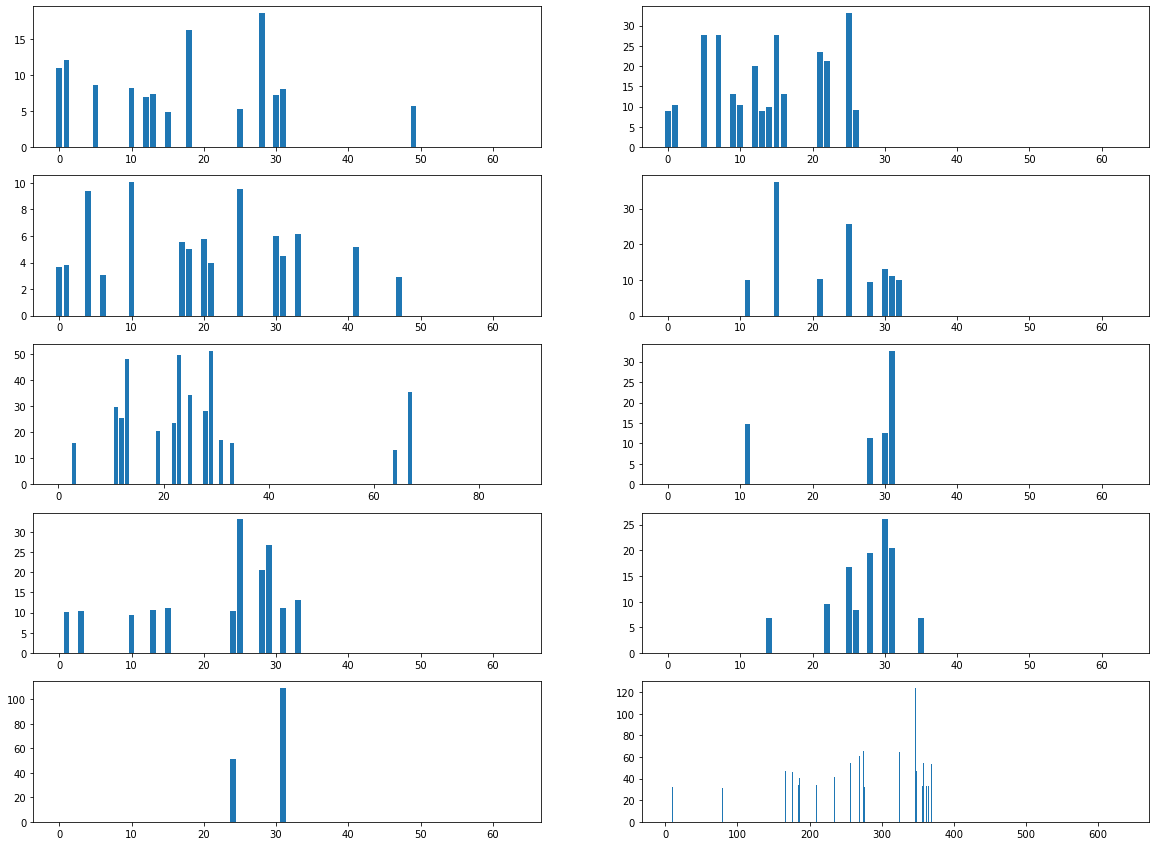

In [110]:
# Feature Selection using correlation
from sklearn.feature_selection import f_regression, SelectKBest
_, ax = plt.subplots(5, 2, figsize=(20,15))
for i in range(10):
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(X_train[i], y[:,i])
#     for j in range(len(fs.scores_)):
#         print('Feature %d: %.4f' %(j, fs.scores_[j]))
    scores = fs.scores_
    scores[scores < scores.max()*0.25] = 0
    print("features to select:", np.where(scores > 0)[0], len(np.where(scores > 0)[0]))
    ax[i // 2, i % 2].bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [125]:
# SELECT with correlation
def select_feature_cor(X_train, y):
    X_train_fs_cor = []
    support = []
    for i in range(10):
        fs = SelectKBest(score_func=f_regression, k=num_features[i])
        fs.fit(X_train[i], y[:,i])
        X_train_fs_cor.append(fs.transform(X_train[i]))
        support.append(fs.get_support(True))
    return X_train_fs_cor, support

X_train_fs_cor, support_fs_cor = select_feature_cor(X_train, y)

features to select: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 37 38 40 43 46 48 50 53 55 58 59 60 61 62
 63] 25
features to select: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 42 44 45 47 49 51 55 58
 59 60 61 62 63] 27
features to select: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 47 48 49
 50 52 53 54 55 57 58 59 61 62 63] 33
features to select: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 38 40 41 43 44 46 49 51 54 55 57 58 59
 60 62 63] 24
features to select: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 18 19 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 38 39 43 44 49 51 53 54 55 58 60 64 65 66 67 71
 72 73 74 75 76 77 78 79 82 84 85 86 87] 27
features to select: [ 0  1  2  3  4  5  6  7  

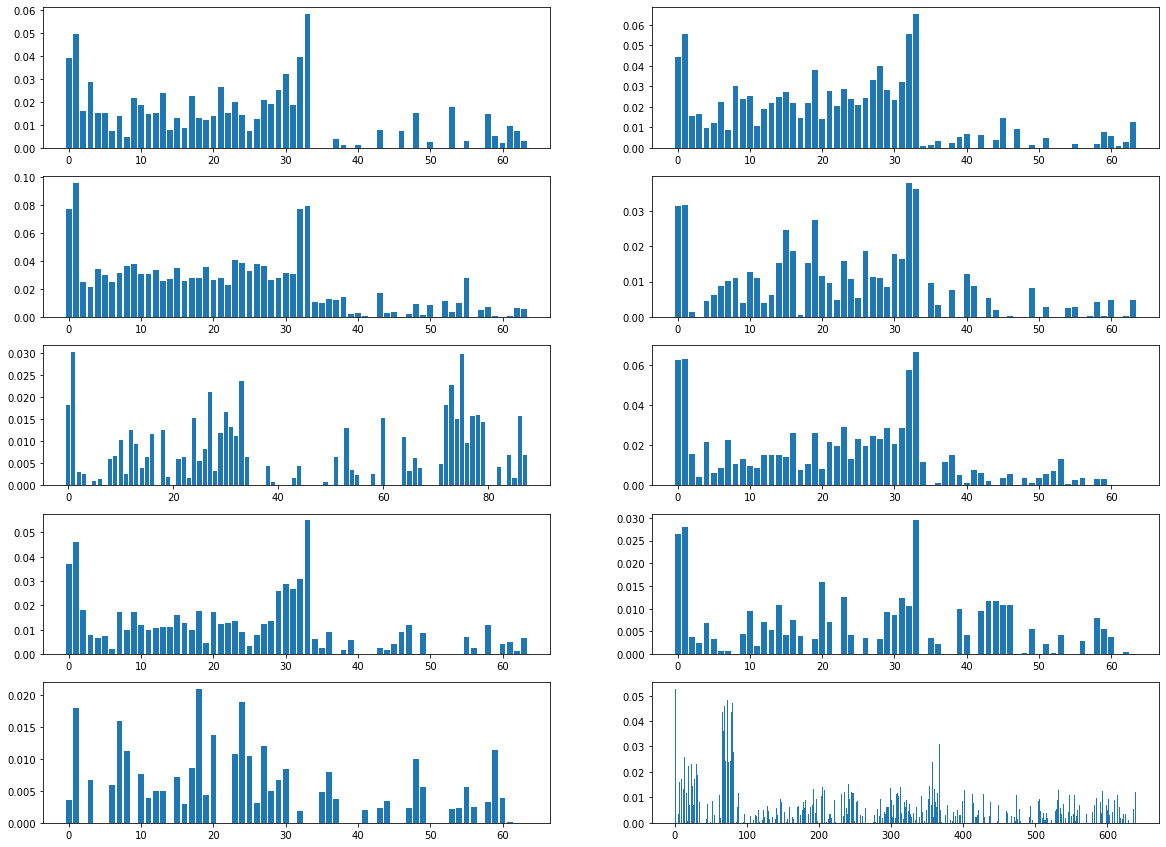

In [109]:
# Feature Selection using mutual information
from sklearn.feature_selection import mutual_info_regression, SelectKBest
_, ax = plt.subplots(5, 2, figsize=(20,15))
for i in range(10):
    fs = SelectKBest(score_func=mutual_info_regression, k='all')
    fs.fit(X_train[i], y[:,i])
    for j in range(len(fs.scores_)):
        print('Feature %d: %.4f' %(j, fs.scores_[j]))
    scores = fs.scores_
    scores[scores < scores.max()*0.25] = 0
    print("features to select:", np.where(scores > 0)[0], len(np.where(scores > 0)[0]))
    ax[i // 2, i % 2].bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [8]:
# SELECT with mutual information
from sklearn.feature_selection import mutual_info_regression, SelectKBest

def select_feature_mi(X_train, y, num_features):
    X_train_fs_mi = []
    support = []
    for i in range(10):
        fs = SelectKBest(score_func=mutual_info_regression, k=num_features[i])
        fs.fit(X_train[i], y[:,i])
        X_train_fs_mi.append(fs.transform(X_train[i]))
        support.append(fs.get_support(True))
    return X_train_fs_mi, support

# X_all, Y_all = sim.dataset.all_data
# y_all = Y_all - X_all[:,0,-1,:]
# X_selected, Y_selected = X_all[1440*60:].copy(), Y_all[1440*60:].copy()
# del X_all
# del Y_all
# X_train = transform_split(X_selected)
# for i in range(10):
#     print(X_train[i].shape)
X_train_fs_mi, support_fs_mi = select_feature_mi(X_train, y, num_features)

In [9]:
import pickle
with open('./support_fs_mi.pkl', 'wb') as f:
    pickle.dump(support_fs_mi, f)

support_fs_mi

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64),
 array([ 0,  1, 19, 23, 25, 28, 29, 31, 32, 33], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64),
 array([ 0,  1,  8,  9, 13, 15, 16, 18, 19, 20, 22, 23, 24, 26, 28, 29, 31,
        32, 33, 35], dtype=int64),
 array([ 0,  1,  8, 16, 27, 29, 30, 31, 32, 33, 72, 73, 74, 75, 77, 78, 79,
        86], dtype=int64),
 array([ 0,  1, 22, 23, 25, 26, 28, 30, 32, 33], dtype=int64),
 array([ 0,  1,  2,  7,  9, 10, 11, 16, 20, 22, 23, 27, 29, 30, 31, 32, 33],
 

In [ ]:
# auto tune hyper parameters
from sklearn.feature_selection import mutual_info_regression, SelectKBest

low = [10, 10, 10, 10, 10, 10, 10, 10, 10, 20]
high = [64, 64, 64, 64, 88, 64, 64, 64, 64, 640]
max_iter = 1000000
def get_r_hat_hyper(A, B):
        X = np.stack([A.values, B.values], axis=0)
        X_test = transform_split(X[np.newaxis,:])
        for i in range(10):
            X_test[i] = X_test[i][:,support_fs_mi[i]]
        pred = [model[i].predict(X_test[i]) for i in range(10)]
        pred = np.array(pred, dtype=float).squeeze()

        return pred

max_score = 0
best_feature_num = low
for it in range(max_iter):
    print("iteration number %d"%it)
    num_features = np.random.randint(low, high)
    X_train_fs_mi, support_fs_mi = select_feature_mi(X_train, y, num_features)
    model = []  # split kernel 5
    for i in range(10):
        model.append(LinearRegression().fit(X_train_fs_mi[i], y[:,i]))
    
    _, _, score = sim.submit(get_r_hat_hyper)
    print("score=", score)
    print("num_features=", num_features)
    if score > max_score or (score == max_score and np.sum(best_feature_num) > np.sum(num_features)):
        max_score = score
        best_feature_num = num_features
        print("best score ever!")
        print("features", num_features)


iteration number 0
Total time used: 8.999s
Pairwise correlation:
	asset 0 = 0.02622
	asset 1 = 0.01986
	asset 2 = 0.03085
	asset 3 = 0.02061
	asset 4 = 0.05443
	asset 5 = 0.02937
	asset 6 = 0.07780
	asset 7 = 0.02302
	asset 8 = 0.08955
	asset 9 = -0.00226
	mean correlation = 0.03694
Overall correlation: 0.02117
Performance beats Ziwei's dummy method!
score= 0.021172520876819857
num_features= [55 43 25 52 52 10 17 57 16 46]
best score ever!
features [55 43 25 52 52 10 17 57 16 46]
iteration number 1
Total time used: 9.136s
Pairwise correlation:
	asset 0 = 0.01441
	asset 1 = 0.03809
	asset 2 = 0.03565
	asset 3 = 0.01720
	asset 4 = 0.06918
	asset 5 = 0.00207
	asset 6 = 0.05097
	asset 7 = 0.01458
	asset 8 = 0.11417
	asset 9 = 0.01399
	mean correlation = 0.03703
Overall correlation: 0.02403
Performance beats Ziwei's dummy method!
score= 0.024025852393906866
num_features= [ 23  26  46  36  37  52  41  21  57 404]
best score ever!
features [ 23  26  46  36  37  52  41  21  57 404]
iteration n

Total time used: 9.258s
Pairwise correlation:
	asset 0 = 0.00346
	asset 1 = 0.02517
	asset 2 = 0.03515
	asset 3 = 0.02762
	asset 4 = 0.05435
	asset 5 = 0.00808
	asset 6 = 0.06026
	asset 7 = 0.02380
	asset 8 = 0.09509
	asset 9 = 0.03926
	mean correlation = 0.03722
Overall correlation: 0.02074
Performance beats Ziwei's dummy method!
score= 0.02074204444071994
num_features= [ 12  53  29  13  51  26  36  59  15 205]
iteration number 17
Total time used: 9.440s
Pairwise correlation:
	asset 0 = 0.02383
	asset 1 = 0.02118
	asset 2 = 0.04166
	asset 3 = 0.01706
	asset 4 = 0.05631
	asset 5 = -0.00072
	asset 6 = 0.03553
	asset 7 = 0.01400
	asset 8 = 0.11552
	asset 9 = 0.01217
	mean correlation = 0.03365
Overall correlation: 0.02120
Performance beats Ziwei's dummy method!
score= 0.021197460698864003
num_features= [ 38  41  52  29  75  31  47  24  48 225]
iteration number 18
Total time used: 9.048s
Pairwise correlation:
	asset 0 = 0.01441
	asset 1 = 0.04829
	asset 2 = 0.04215
	asset 3 = 0.02767
	ass

Total time used: 9.391s
Pairwise correlation:
	asset 0 = 0.02033
	asset 1 = 0.03962
	asset 2 = 0.03576
	asset 3 = 0.01836
	asset 4 = 0.05366
	asset 5 = -0.00062
	asset 6 = 0.04179
	asset 7 = 0.01729
	asset 8 = 0.09666
	asset 9 = 0.00947
	mean correlation = 0.03323
Overall correlation: 0.01880
Performance beats Ziwei's dummy method!
score= 0.01880143034584424
num_features= [ 17  32  14  25  53  63  29  18  27 271]
iteration number 34
Total time used: 9.543s
Pairwise correlation:
	asset 0 = 0.02614
	asset 1 = 0.04119
	asset 2 = 0.03950
	asset 3 = 0.02113
	asset 4 = 0.05798
	asset 5 = -0.00072
	asset 6 = 0.04613
	asset 7 = 0.02253
	asset 8 = 0.06808
	asset 9 = 0.01233
	mean correlation = 0.03343
Overall correlation: 0.02255
Performance beats Ziwei's dummy method!
score= 0.02254818313813569
num_features= [60 19 16 53 86 14 31 50 17 36]
iteration number 35
Total time used: 9.704s
Pairwise correlation:
	asset 0 = 0.01902
	asset 1 = 0.03823
	asset 2 = 0.03576
	asset 3 = 0.01386
	asset 4 = 0.0

Total time used: 9.243s
Pairwise correlation:
	asset 0 = 0.01902
	asset 1 = 0.04334
	asset 2 = 0.03483
	asset 3 = 0.02718
	asset 4 = 0.05591
	asset 5 = -0.00249
	asset 6 = 0.03670
	asset 7 = 0.02026
	asset 8 = 0.10625
	asset 9 = -0.00529
	mean correlation = 0.03357
Overall correlation: 0.02151
Performance beats Ziwei's dummy method!
score= 0.021510210712303992
num_features= [ 20  17  45  17  58  33  54  33  38 567]
iteration number 51
Total time used: 9.268s
Pairwise correlation:
	asset 0 = 0.01861
	asset 1 = 0.02499
	asset 2 = 0.03716
	asset 3 = 0.02718
	asset 4 = 0.06988
	asset 5 = 0.00118
	asset 6 = 0.06162
	asset 7 = 0.01047
	asset 8 = 0.09649
	asset 9 = 0.00302
	mean correlation = 0.03506
Overall correlation: 0.02067
Performance beats Ziwei's dummy method!
score= 0.02066860025748624
num_features= [ 18  58  24  17  34  27  37  11  26 276]
iteration number 52
Total time used: 9.448s
Pairwise correlation:
	asset 0 = 0.02319
	asset 1 = 0.02640
	asset 2 = 0.03877
	asset 3 = 0.01788
	as

Total time used: 9.773s
Pairwise correlation:
	asset 0 = 0.02607
	asset 1 = 0.04168
	asset 2 = 0.03422
	asset 3 = 0.02762
	asset 4 = 0.05756
	asset 5 = -0.00259
	asset 6 = 0.03728
	asset 7 = 0.02500
	asset 8 = 0.09687
	asset 9 = 0.01044
	mean correlation = 0.03542
Overall correlation: 0.02271
Performance beats Ziwei's dummy method!
score= 0.022712723547481155
num_features= [ 61  20  33  13  71  13  63  61  14 258]
iteration number 68
Total time used: 9.349s
Pairwise correlation:
	asset 0 = 0.01914
	asset 1 = 0.02620
	asset 2 = 0.04221
	asset 3 = 0.01539
	asset 4 = 0.05940
	asset 5 = 0.00445
	asset 6 = 0.05153
	asset 7 = 0.01794
	asset 8 = 0.11286
	asset 9 = 0.03767
	mean correlation = 0.03868
Overall correlation: 0.02428
Performance beats Ziwei's dummy method!
score= 0.02428436020957346
num_features= [21 62 19 46 46 16 39 44 50 33]
iteration number 69
Total time used: 9.672s
Pairwise correlation:
	asset 0 = 0.02563
	asset 1 = 0.03599
	asset 2 = 0.03505
	asset 3 = 0.01972
	asset 4 = 0.0

In [26]:
last_price = X[:,0,-1,:]
print(last_price.shape, y.shape)

(17709, 10) (17709, 10)


In [38]:
res = np.corrcoef(last_price[:,0], y[:,7])
print(res.shape)
print(res)

(2, 2)
[[1.         0.75285691]
 [0.75285691 1.        ]]


In [40]:
fitted = LinearRegression().fit(last_price, y)
error = y - fitted.predict(last_price)

In [43]:
second_last_price = X[:,0,-2,:]
print(second_last_price.shape)

(17709, 10)


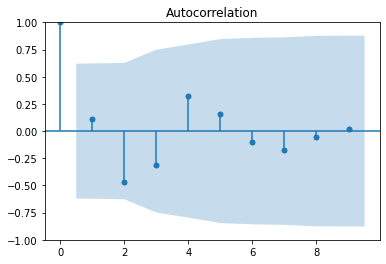

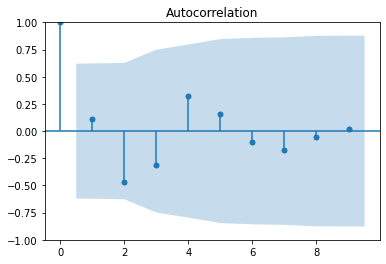

In [46]:
plot_acf(error[0])

In [17]:
# using only the last price to predict
model = LinearRegression().fit(X_train.reshape(len(X_train), -1), y)

In [18]:
model.score(X_train.reshape(len(X_train), -1), y)

0.9985892808567882

In [80]:
# test dependencies on the diff
diff_price = X[:,0,1:,:] - X[:,0,:-1,:]
last_diff = diff_price[:,-1,:]
np.corrcoef(last_diff[:,0], y[:,0])

array([[ 1.        , -0.00776907],
       [-0.00776907,  1.        ]])

In [71]:
# linear gression with only last price and the 30th last price
# ####################################################
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = model.predict(X_test.reshape(len(X_test), -1))
    return pred - A.values[-1]

sim.submit(get_r_hat)

(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


In [75]:
# linear gression with only ::30
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = model.predict(X_test.reshape(len(X_test), -1))
    return pred - A.values[-1]

sim.submit(get_r_hat)

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

In [81]:
# linear gression with only last price and the 30th last price no diff
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = model.predict(X_test.reshape(len(X_test), -1))
    return pred - A.values[-1]

sim.submit(get_r_hat)

(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


In [85]:
# linear gression with 1, 29, -1, -30
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = model.predict(X_test.reshape(len(X_test), -1))
    return pred - A.values[-1]

sim.submit(get_r_hat)

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

In [90]:
# Try logistic regression without log volumes
from sklearn.linear_model import LogisticRegression
y_logistic = (y > 0).astype(int)
model_logistic = []
print(X_train.shape)
for i in range(10):
    model_logistic.append(LogisticRegression().fit(X_train[:,:,i], y_logistic[:,i]))
    print(i)

(17709, 8, 10)
0
1
2
3
4
5
6
7
8
9


In [93]:
# Logistic regression without log volumes
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = np.array([model_logistic[i].predict(X_test[:,:,i]) for i in range(10)], dtype=float)
    pred = (pred.squeeze() - 0.5) * 2 * A.values.max(axis=0) + np.random.randn(10) * 1e-8
    return pred - A.values[-1]

sim.submit(get_r_hat)

(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


In [32]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train.reshape(len(X_train),-1), y)
y.shape

(17709, 10)

In [33]:
model.score(X_train.reshape(len(X_train), -1), y)

0.9985892278993012

In [30]:
# checks for more volume
# linear gression with only last price and the 30th last price
# ####################################################
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = model.predict(X_test.reshape(len(X_test), -1))
    return pred - A.values[-1]

sim.submit(get_r_hat)

Total time used: 3.171s
Pairwise correlation:
	asset 0 = 0.00655
	asset 1 = 0.00704
	asset 2 = -0.02376
	asset 3 = -0.02055
	asset 4 = -0.00305
	asset 5 = -0.00693
	asset 6 = 0.00049
	asset 7 = -0.01817
	asset 8 = -0.03639
	asset 9 = -0.03210
	mean correlation = -0.01269
Overall correlation: -0.00804
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)
